# Support Vector Machines Predict Food Ratings -- Kristofer Schobert

In this notebook we will follow Thinkful's treatment of a dataset containing many dishes in a potential cookbook. We initially try using Support Vector Regression to predict the ratings, then try classifying as a dish's rating as good or bad with Support Vector Classification.

We will try many kernel's and methods of feature reduction to find the best Support Vector Machine for our dataset. 

In [35]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline

In [3]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [6]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [7]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [8]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


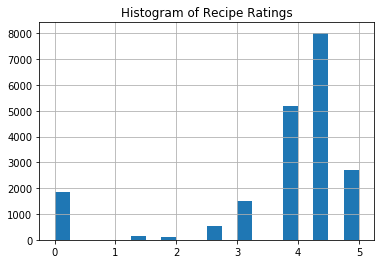

In [9]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [10]:
raw_data['rating'].unique()

array([2.5  , 4.375, 3.75 , 5.   , 3.125, 1.875, 0.   , 1.25 ])

In [11]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [50]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.1, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

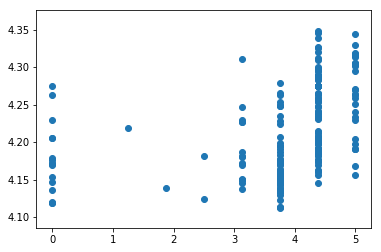

In [30]:
plt.scatter(Y, svr.predict(X))

In [51]:
svr.score(X, Y)

-0.05542361721037614

In [52]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.03730995, -0.11035845, -0.06425526, -0.15114749, -0.049069  ])

# Using a Binary Classifier

Instead of treating this as a regression problem, we are now going to treat it as a binary classifier. 

From this cross validation score, it is obvious that using all the features (aside from those with null values) and treating this as a regression problem is not working well. Our outcome variable is not continuous. There are 8 possible values for the rating of these foods. We could try to using support vector machines to classify the data into these eight catagories but we would lose the ordinal nature of the ratings. 

As the Thinkful challenge suggests, we will convert this outcome variable into a binary variable. We will use the median to inform out cutoff rating. Ratings of 4.375 or 5 will be a positive rating (i.e. True) and ratings lower will be a negative rating (i.e. False).

We will also want to reduce the number of features we have, but first let's make this adjustment to a binary outcome. 

In [25]:
raw_data['binary_rating'] = raw_data['rating'] >= 4.375
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey,binary_rating
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Let's begin testing different Support Vector Classifiers with different kernels

Note that we will test on 1/10th of the data, since our dataset is so large. When we find a promising model, we will test on more of the data.

In [46]:
## Kernel is the radial basis function

svc = SVC(kernel= 'rbf')
X = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.543640897755611

Confusion Matrix: 
[[   0  915]
 [   0 1090]]

 10-Fold Cross Validation 
[0.54228856 0.54228856 0.54228856 0.54228856 0.54228856 0.545
 0.545      0.545      0.545      0.545     ]

 Cross Validation Score Statistics: 0.54364 (+/- 0.00271)


From this confusion matrix, we see that we are always predicting all instances to be a high rating. This is an issue. Let's try a different kernel. We are using the radial basis function as out kerne. Instead, we will try 'linear'.

In [55]:
## Using a linear kernel


svc = SVC(kernel= 'linear')
X = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))




Accuracy Score: 0.7386533665835412

Confusion Matrix: 
[[620 295]
 [229 861]]

 10-Fold Cross Validation 
[0.58706468 0.62189055 0.60199005 0.62189055 0.52736318 0.575
 0.565      0.565      0.56       0.57      ]

 Cross Validation Score Statistics: 0.57952 (+/- 0.05581)


We see some improvement with this new kernel type. Let's try the others anyways. 

In [43]:
## Using a polynomial kernel of degree 3
svc = SVC(kernel= 'poly')
X = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))


Accuracy Score: 0.543640897755611

Confusion Matrix: 
[[   0  915]
 [   0 1090]]

 10-Fold Cross Validation: 
[0.54228856 0.54228856 0.54228856 0.54228856 0.54228856 0.545
 0.545      0.545      0.545      0.545     ]

 Cross Validation Score Statistics: 0.54364 (+/- 0.00271)


In [45]:
## Using a sigmoid kernel

from sklearn.svm import SVC
svc = SVC(kernel= 'sigmoid')
X = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))


Accuracy Score: 0.543640897755611

Confusion Matrix: 
[[   0  915]
 [   0 1090]]

 10-Fold Cross Validation: 
[0.54228856 0.54228856 0.54228856 0.54228856 0.54228856 0.545
 0.545      0.545      0.545      0.545     ]

 Cross Validation Score Statistics: 0.54364 (+/- 0.00271)


Alright. So we should definitely go with a linear kernel here. All the others always predict that that food has a high rating... Now to reduce the features.

Let's see which features are most correlated with the rating. That will help guide us to picking 30 of the 600 features. 

## Feature Reduction via Correlation with Outcome

In [47]:
corr_with_rating = raw_data.corr()['rating']

In [48]:
print(abs(corr_with_rating).sort_values()[-31:-1])

kosher            0.059071
chartreuse        0.059753
weelicious        0.060289
dinner            0.060957
créme de cacao    0.061670
pernod            0.062768
fortified wine    0.063814
brandy            0.065481
sauté             0.066553
fall              0.067343
roast             0.073499
condiment         0.076295
bake              0.076978
non-alcoholic     0.077476
tree nut free     0.081347
rum               0.084689
liqueur           0.090757
soy free          0.092965
peanut free       0.096087
harpercollins     0.105094
bon appétit       0.124549
bitters           0.137368
cocktail party    0.140482
cocktail          0.140723
spirit            0.146625
gin               0.191400
house & garden    0.217911
alcoholic         0.224767
drink             0.241388
binary_rating     0.655698
Name: rating, dtype: float64


In [49]:
corr_features = abs(corr_with_rating).sort_values()[-31:-1].index

In [50]:
data = raw_data[corr_features]

In [57]:
# Let's use support vector machines using those 30 well correlated features as input variables.

# using a linear kernel

from sklearn.svm import SVC
svc = SVC(kernel= 'linear')
X = data.drop(['binary_rating'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5720698254364089

Confusion Matrix: 
[[ 100  815]
 [  43 1047]]

 10-Fold Cross Validation: 
[0.55223881 0.60199005 0.55721393 0.58706468 0.56218905 0.555
 0.555      0.565      0.56       0.56      ]

 Cross Validation Score Statistics: 0.56557 (+/- 0.03055)


Well that didnt work well. I wonder if a different kernel that did not work well before will work well now. 

In [58]:
## Using a radial basis function kernel 

from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
X = data.drop(['binary_rating'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5680798004987531

Confusion Matrix: 
[[  77  838]
 [  28 1062]]

 10-Fold Cross Validation: 
[0.54228856 0.57711443 0.55223881 0.60199005 0.55721393 0.565
 0.545      0.55       0.565      0.57      ]

 Cross Validation Score Statistics: 0.56258 (+/- 0.03374)


Wow, I am suprized that this kernel which predicted a high value for every instance when using all the features is not performing better. It is roughly as good of a model as the SVM with a linear kernel. Let's try the other kernels. 

In [59]:
## Using a polynomial kernel of degree 3

from sklearn.svm import SVC
svc = SVC(kernel = 'poly')
X = data.drop(['binary_rating'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.543640897755611

Confusion Matrix: 
[[   0  915]
 [   0 1090]]

 10-Fold Cross Validation: 
[0.54228856 0.54228856 0.54228856 0.54228856 0.54228856 0.545
 0.545      0.545      0.545      0.545     ]

 Cross Validation Score Statistics: 0.54364 (+/- 0.00271)


A polynomial kernel (default of degree 3) is still no good. After trying the others, we find that degree 1 is the best. It is still not as good as a 'linear' kernel. My instinct is that they should be the same exact kernel, but there must be more going on that I am unaware of. 

In [60]:
# our kernel is polynomial and our degree is 1. This does not produce the same predictions as a 'linear' kernel. 
# I have not looked into why this is just yet. 
from sklearn.svm import SVC
svc = SVC(kernel = 'poly', degree = 1)
X = data.drop(['binary_rating'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5610972568578554

Confusion Matrix: 
[[  60  855]
 [  25 1065]]

 10-Fold Cross Validation: 
[0.54726368 0.58208955 0.55721393 0.59701493 0.55721393 0.55
 0.545      0.545      0.55       0.565     ]

 Cross Validation Score Statistics: 0.55958 (+/- 0.03292)


In [61]:
## Using a sigmoid kernel

from sklearn.svm import SVC
svc = SVC(kernel = 'sigmoid')
X = data.drop(['binary_rating'], 1).sample(frac=0.1, replace=True, random_state=1)
Y = data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5610972568578554

Confusion Matrix: 
[[  60  855]
 [  25 1065]]

 10-Fold Cross Validation: 
[0.54726368 0.58208955 0.55721393 0.59701493 0.55721393 0.55
 0.545      0.545      0.55       0.565     ]

 Cross Validation Score Statistics: 0.55958 (+/- 0.03292)


A polynomial kernel with degree 1 is the same as a sigmoid kernel? I am very suprized by this. I will have to look into what is going on in more detail. Maybe the names of kernels are not as telling as I think maybe. 

## Let's try using Principal Component Analysis

In [23]:
# Creating the Principal Components

from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
pca = PCA(n_components=30)
clean_data = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.1, replace=True, random_state=1)
data_pca = pca.fit_transform(clean_data)


In [62]:
# Using a sigmoid kernel

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'sigmoid')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5815461346633416

Confusion Matrix: 
[[174 741]
 [ 98 992]]

 10-Fold Cross Validation: 
[0.53233831 0.59701493 0.55223881 0.60696517 0.56218905 0.54
 0.545      0.57       0.565      0.59      ]

 Cross Validation Score Statistics: 0.56607 (+/- 0.04769)


In [63]:
# Using a linear kernel

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5955112219451372

Confusion Matrix: 
[[371 544]
 [267 823]]

 10-Fold Cross Validation: 
[0.51243781 0.56716418 0.58208955 0.60696517 0.55721393 0.57
 0.6        0.605      0.58       0.57      ]

 Cross Validation Score Statistics: 0.57509 (+/- 0.05278)


In [64]:
# Using a polynomial kernel of degree 3

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'poly')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.543640897755611

Confusion Matrix: 
[[   0  915]
 [   0 1090]]

 10-Fold Cross Validation: 
[0.54228856 0.54228856 0.54228856 0.54228856 0.54228856 0.545
 0.545      0.545      0.545      0.545     ]

 Cross Validation Score Statistics: 0.54364 (+/- 0.00271)


In [66]:
# Using a radial basis function kernel

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.1, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.6134663341645885

Confusion Matrix: 
[[325 590]
 [185 905]]

 10-Fold Cross Validation: 
[0.54228856 0.6119403  0.58208955 0.5721393  0.54228856 0.535
 0.61       0.61       0.575      0.55      ]

 Cross Validation Score Statistics: 0.57307 (+/- 0.05727)


Of all these kernels, linear and rbf seem to have the highest cross validation score. The rbf model has the highest accuracy score. Let's see how they preform on more of the data than 1/10th. 

In [67]:
pca = PCA(n_components=30)
clean_data = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.5, replace=True, random_state=1)
data_pca = pca.fit_transform(clean_data)


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.5, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.601835228406144

Confusion Matrix: 
[[2089 2541]
 [1451 3945]]

 10-Fold Cross Validation: 
[0.57328016 0.58225324 0.57627119 0.56331007 0.6111665  0.58823529
 0.58782435 0.58183633 0.57784431 0.59281437]

 Cross Validation Score Statistics: 0.58348 (+/- 0.02445)


In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
X = data_pca
Y = raw_data.binary_rating.sample(frac=0.5, replace=True, random_state=1)
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5742070616397367

Confusion Matrix: 
[[2000 2630]
 [1639 3757]]

 10-Fold Cross Validation: 
[0.57128614 0.57328016 0.55134596 0.56430708 0.61216351 0.56729811
 0.55988024 0.5748503  0.55688623 0.55888224]

 Cross Validation Score Statistics: 0.56902 (+/- 0.03219)


It seems the radial basis function is best. It has a better accuracy score and cross validation score. Perhaps, it most often always works well, and that is why it as listed as the default kernel. 

Let's see how it performs on the data as a whole. 

In [70]:
pca = PCA(n_components=30)
clean_data = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
data_pca = pca.fit_transform(clean_data)

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
X = data_pca
Y = raw_data.binary_rating
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))

Accuracy Score: 0.5910133652503491

Confusion Matrix: 
[[3528 5786]
 [2415 8323]]

 10-Fold Cross Validation: 
[0.59371884 0.56929212 0.56131605 0.59272183 0.56508728 0.58503741
 0.59501247 0.57157107 0.58483034 0.56836327]

 Cross Validation Score Statistics: 0.57870 (+/- 0.02449)


## Conclusion

Well, when all the data is used, our model seems to perform just slightly worse. Overall, we have found that using a radial basis function with principal component analysis, has been the most effective model. 

Using a tenth of the data and all of the original features earned the highest accuracy score, but a similar cross validation score to that of the PCA rbf model. 


## New Technique

My mentor has told me about the t-distributed Stochastic Neighbor Embedding. After doing some research on the method and having a basic understanding of how it works, I tried it below.

In [74]:
from sklearn.manifold import TSNE
clean_data = raw_data.drop(['rating', 'binary_rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
X = TSNE(n_components=2).fit_transform(clean_data)


from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
#X = data_pca
Y = raw_data.binary_rating
svc.fit(X,Y)

print('Accuracy Score: ' + str(svc.score(X, Y)) + '\n')
print('Confusion Matrix: \n' + str(confusion_matrix(Y, svc.predict(X))))
cross_score = cross_val_score(svc, X, Y, cv=10)
print('\n 10-Fold Cross Validation: \n' + str(cross_score))
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cross_score.mean(), cross_score.std() * 2))




Accuracy Score: 0.725314183123878

Confusion Matrix: 
[[6028 3286]
 [2222 8516]]

 10-Fold Cross Validation: 
[0.5892323  0.59272183 0.58624128 0.58673978 0.58204489 0.5915212
 0.60897756 0.60498753 0.59481038 0.58632735]

 Cross Validation Score Statistics: 0.59236 (+/- 0.01630)


This is the good model. It's accuracy score roughly as good as the accuracy score that used every feature, while its cross validation score is the best we have seen.

One drawback to this model is how long it takes to run. 